In [14]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
import matplotlib.pyplot as plt

In [2]:
MASK_DIR = "/home/sam/dissertation/mask_image"
DATA_DIR="/home/sam/dissertation/fish_image"
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'fishCNN_oct_parallel-{}-{}.model'.format(LR, '2conv-basic')

def createData():
    data=[]
    mask=[]
    for dir in tqdm(os.listdir(DATA_DIR)):
        mask_path = os.path.join(MASK_DIR,dir)
        img_path=os.path.join(DATA_DIR,dir)
        label=dir.split('_')[-1];
        oneHotLabel=np.zeros(23);
        oneHotLabel[int(label)-1]=1;
        for img in tqdm(os.listdir(img_path)):
            path = os.path.join(img_path,img)
            imgData = cv2.imread(path)
            imgData = cv2.resize(imgData, (IMG_SIZE,IMG_SIZE))
            
            
            mpath = os.path.join(mask_path,img)
            mpath=mpath.replace("fish","mask")
            mask= cv2.imread(mpath,cv2.IMREAD_GRAYSCALE)
            
#             print mpath
#             print mask.shape
            mask=cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
            
            imgData=np.dstack((imgData,mask))
            
            data.append([np.array(imgData),np.array(oneHotLabel)])
            
    shuffle(data)
    np.save('data_masked_parallel.npy', data)
    return data

In [9]:
data=np.load("data_masked_parallel.npy", allow_pickle=True)

In [5]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/sam/dissertation/fishCNN_oct_parallel-0.001-2conv-basic.model
model loaded!


In [4]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 4], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 23, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log_mask')

/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/tensorf

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [10]:
train = data[:-int(len(data)/20)]
test = data[-int(len(data)/20):]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
test_y = [i[1] for i in test]

#X.dtype

# X=X.view('float32')
# test_x/=test_x.view('float32')

# test_x
test_x.size

54720000

In [8]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1220  | total loss: 0.19130 | time: 270.200s
| Adam | epoch: 003 | loss: 0.19130 - acc: 0.9540 -- iter: 25984/26002
Training Step: 1221  | total loss: 0.17799 | time: 275.151s
| Adam | epoch: 003 | loss: 0.17799 - acc: 0.9555 | val_loss: 0.14052 - val_acc: 0.9649 -- iter: 26002/26002
--


In [9]:
 model.save(MODEL_NAME)

INFO:tensorflow:/home/sam/dissertation/fishCNN_oct_parallel-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [10]:
np.dstack(test_x[5,:,:,np.array([0,1,2])]).shape

(100, 100, 3)

In [11]:
cv2.imshow('fish',X[1,:,:,1:4])

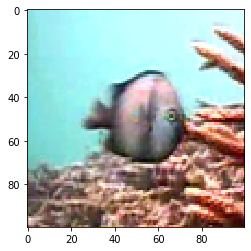

[[9.9998832e-01 1.4960243e-07 3.0396606e-07 9.8569846e-09 5.8747784e-10
  1.0590509e-05 5.0357921e-12 1.9647958e-07 2.1159541e-11 3.3635493e-16
  3.3664845e-11 1.7930551e-08 1.0255135e-12 3.6985665e-07 2.5584840e-11
  3.2452766e-14 2.8912114e-08 1.7086799e-14 1.8016314e-09 1.8613368e-09
  1.0808835e-09 8.5000558e-09 1.0100514e-09]]
[[ 0  5 13  2  7  1 16 11  3 21 19 18 20 22  4 10 14  8  6 12 15 17  9]]


In [15]:
n = 40
plt.imshow(np.dstack(test_x[n,:,:,np.array([2,1,0])]))
plt.show()

print (model.predict([test_x[n]]))
print (model.predict_label([test_x[n]]))